# Imports

In [63]:
import data_pipeline

import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #; sns.set(style="dark"); sns.set_palette("colorblind")

import itertools
import json

# Get the data

In [5]:
SEASON_2019_FILE_NAME = "full_season.json"

In [6]:
with open(SEASON_2019_FILE_NAME, "r") as f:
    data = json.load(f)
    data = list(itertools.chain.from_iterable(data))

##### Threshold 15mins, 25percentile

In [7]:
# min_mins_played prunes all rows with under 14 mins played in that game
df = data_pipeline.stats_endpoint_data_pipeline(data=data, min_mins_played=14)

### Games played (David)

In [16]:
df_games_played = pd.DataFrame(data=df['player_name'].value_counts())
# df_games_played = pd.DataFrame(df_games_played)
df_games_played = df_games_played.reset_index()
df_games_played.columns = ['player_name', 'games_played'] # change column names

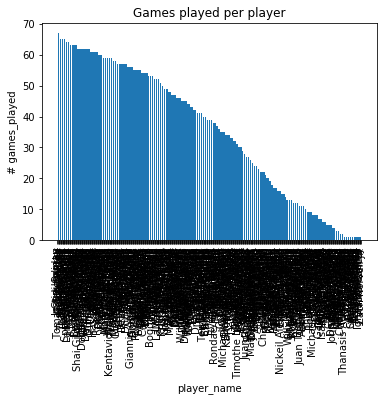

In [17]:
plt.figure()
plt.bar(df_games_played['player_name'].unique(), df_games_played['games_played'])
plt.xlabel('player_name')
plt.ylabel("# games_played")
plt.title("Games played per player")
plt.xticks(rotation=90)
plt.show();

In [19]:
df_games_played.describe()

,games_played
count,460.000000
mean,35.469565
std,21.303828
min,1.000000
25%,14.000000
50%,39.000000
75%,55.250000
max,67.000000


##### Threshold 14 games, 25percentile

In [21]:
df2 = df.merge(df_games_played, left_on='player_name', right_on='player_name')
df3 = df2.loc[df2['games_played'] > 13]
print(len(df2),len(df3))
print(len(df3)/len(df2))

16316 15594
0.9557489580779602


In [22]:
df = df3.copy()
del df2; del df3

# Analysis

## Performance score distribution

In [23]:
PERF_GRADING_NUMERIC_COLS = data_pipeline.PERF_GRADING_NUMERIC_COLS
# ["assists", "blocks", "rebounds", "points", "steals", "turnovers", "personal_fouls","one_pt_attempts","two_pt_attempts","three_pt_attempts"]

In [14]:
df['three_pt_attempts'].unique()

array([ 5,  6,  7, 12,  4,  3,  9,  2,  8, 10, 11,  0,  1, 13, 20, 15, 14,
       16, 17, 21, 19, 22, 18], dtype=int64)

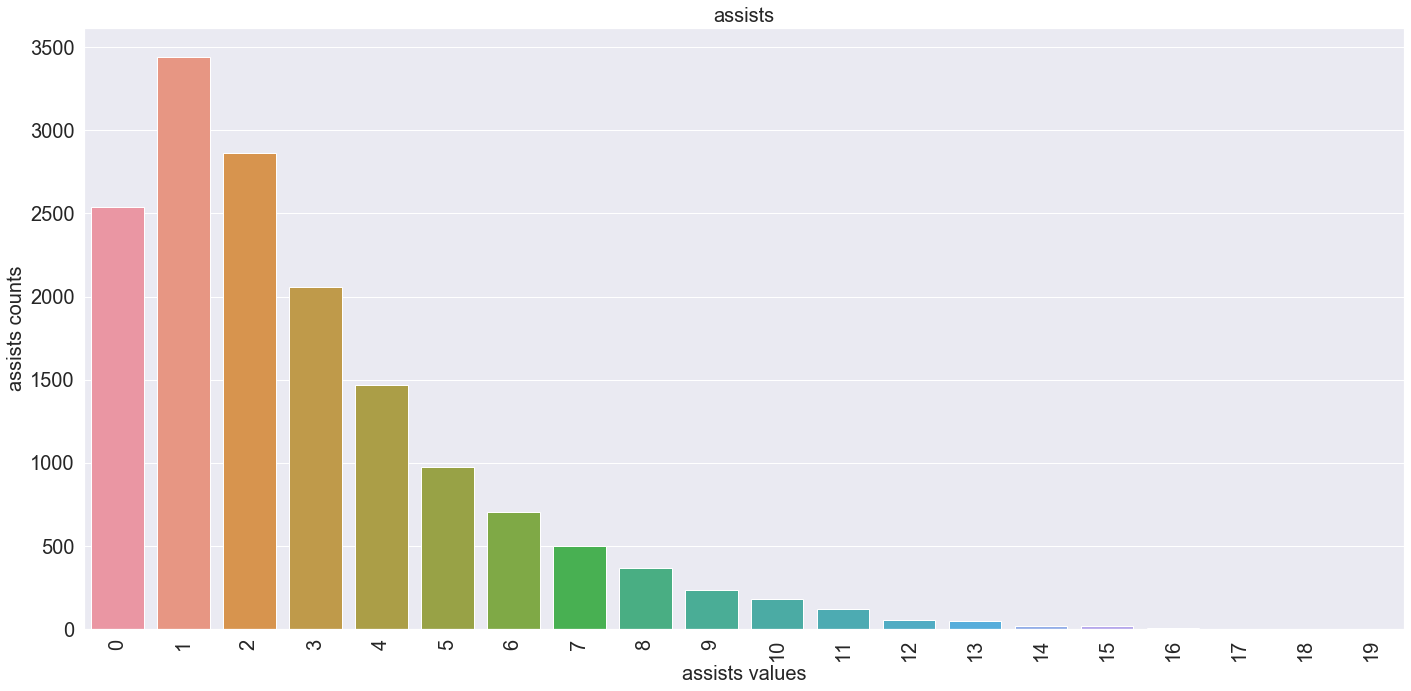

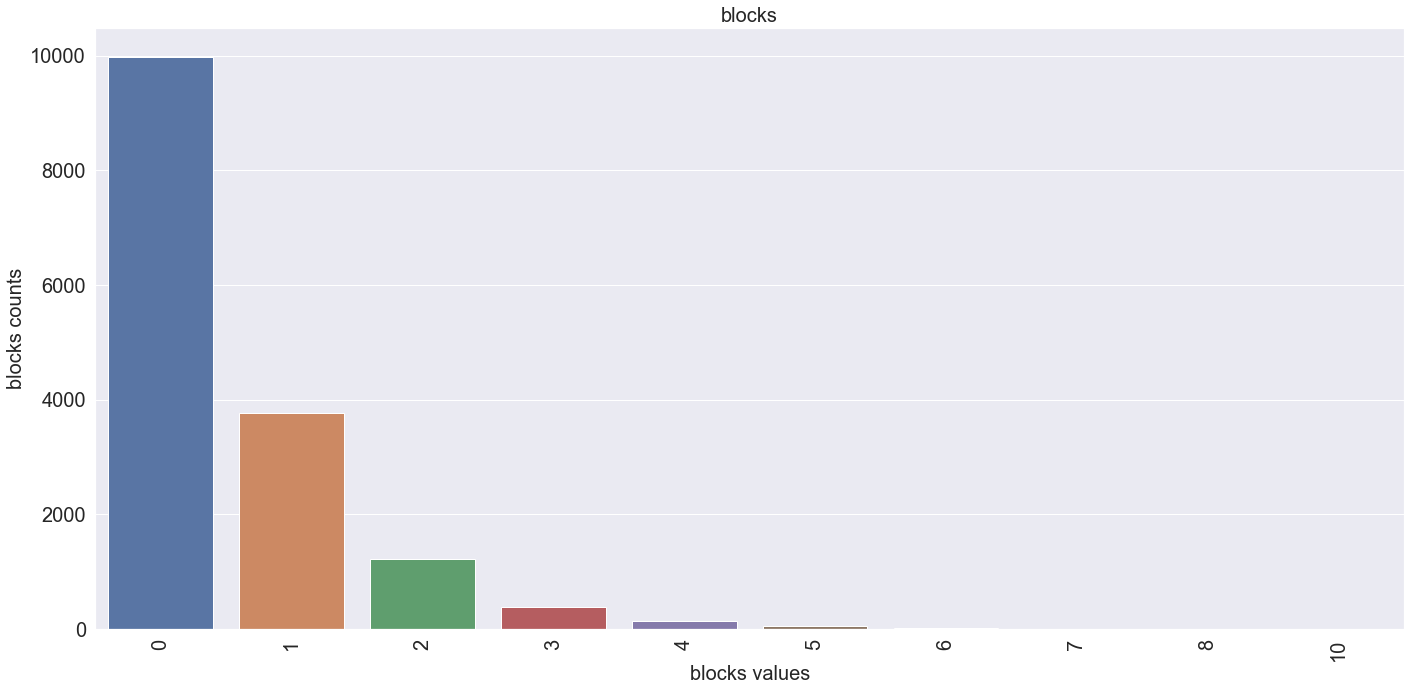

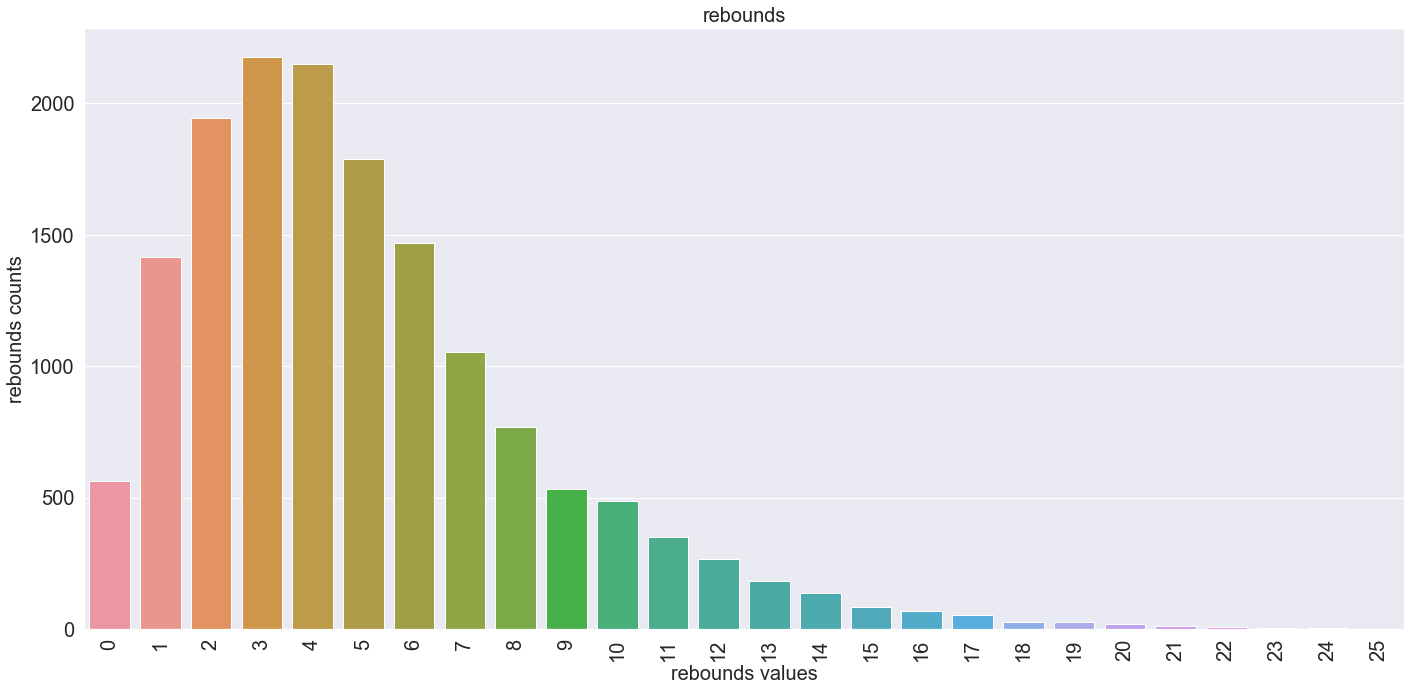

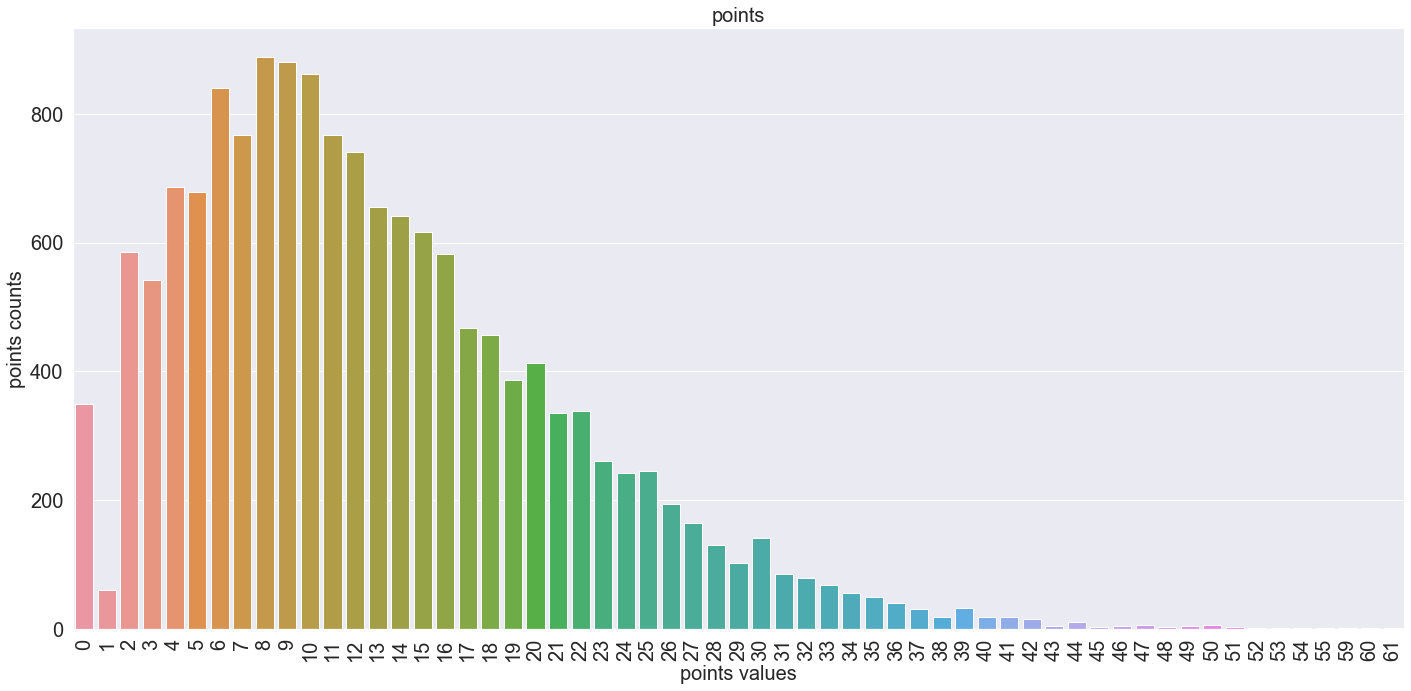

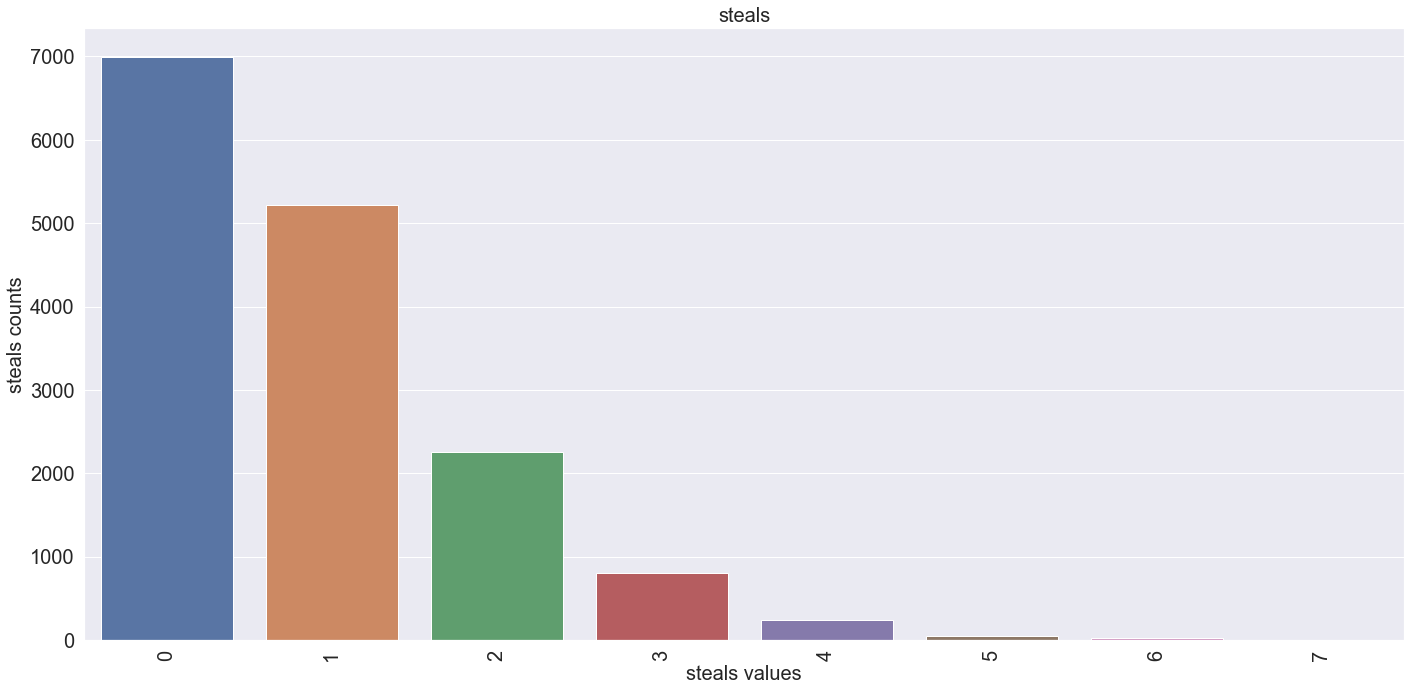

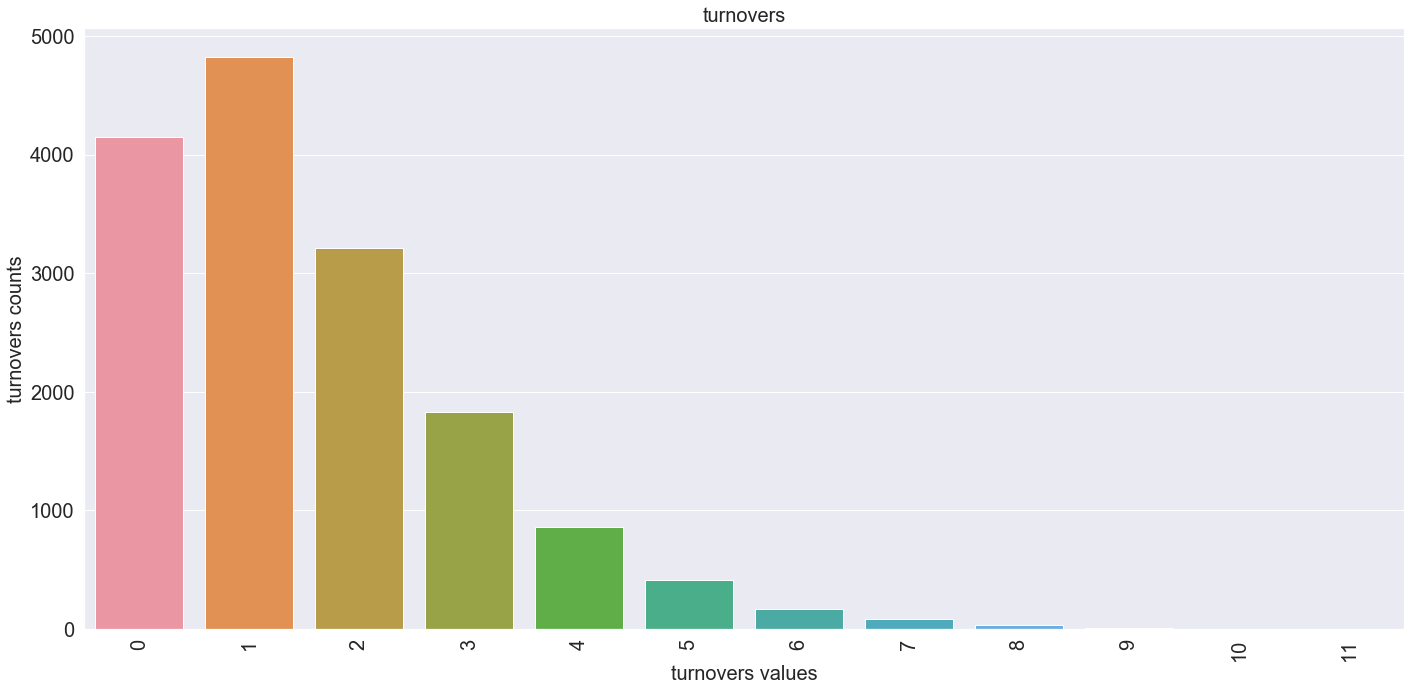

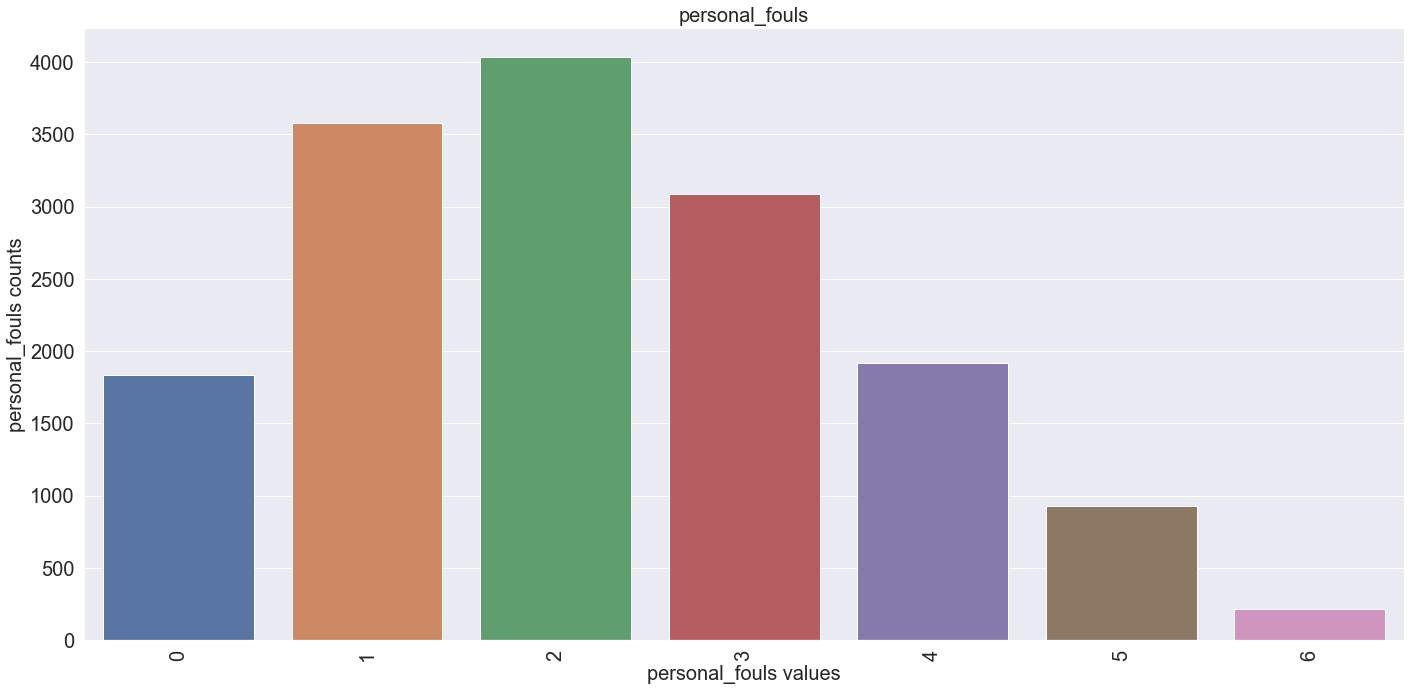

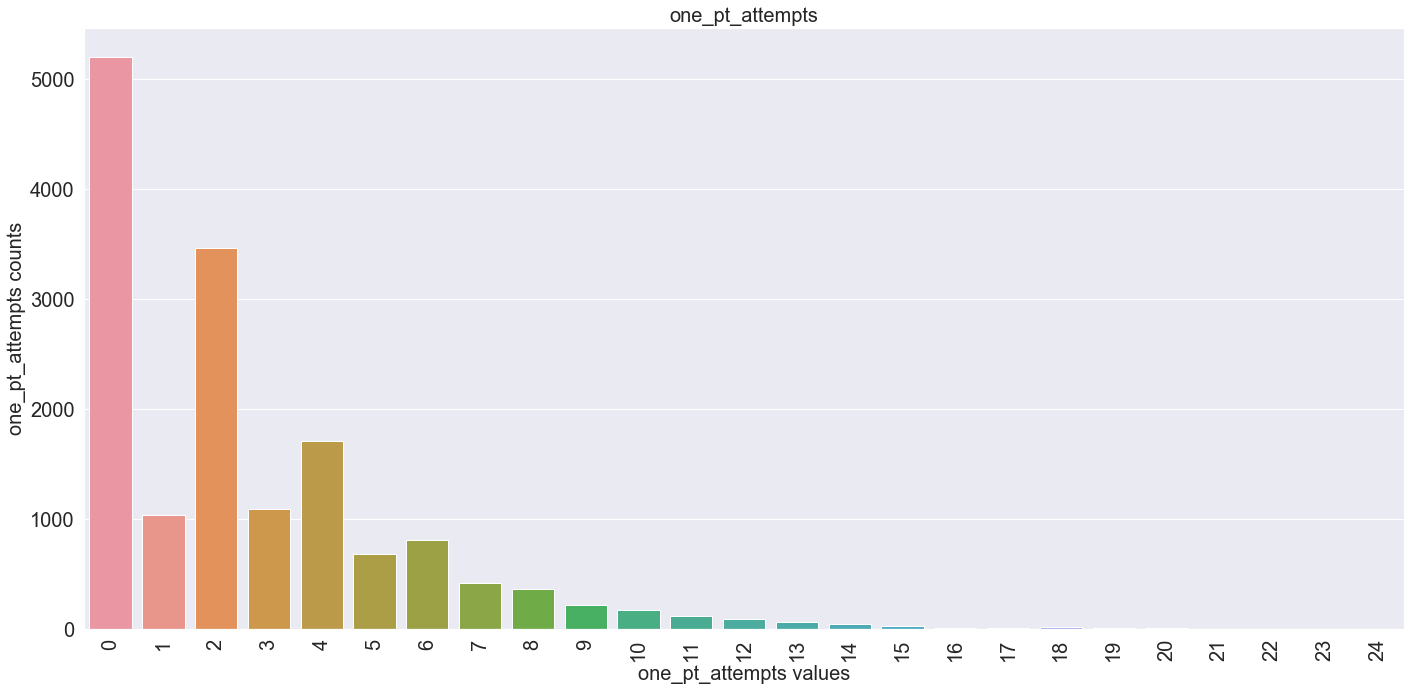

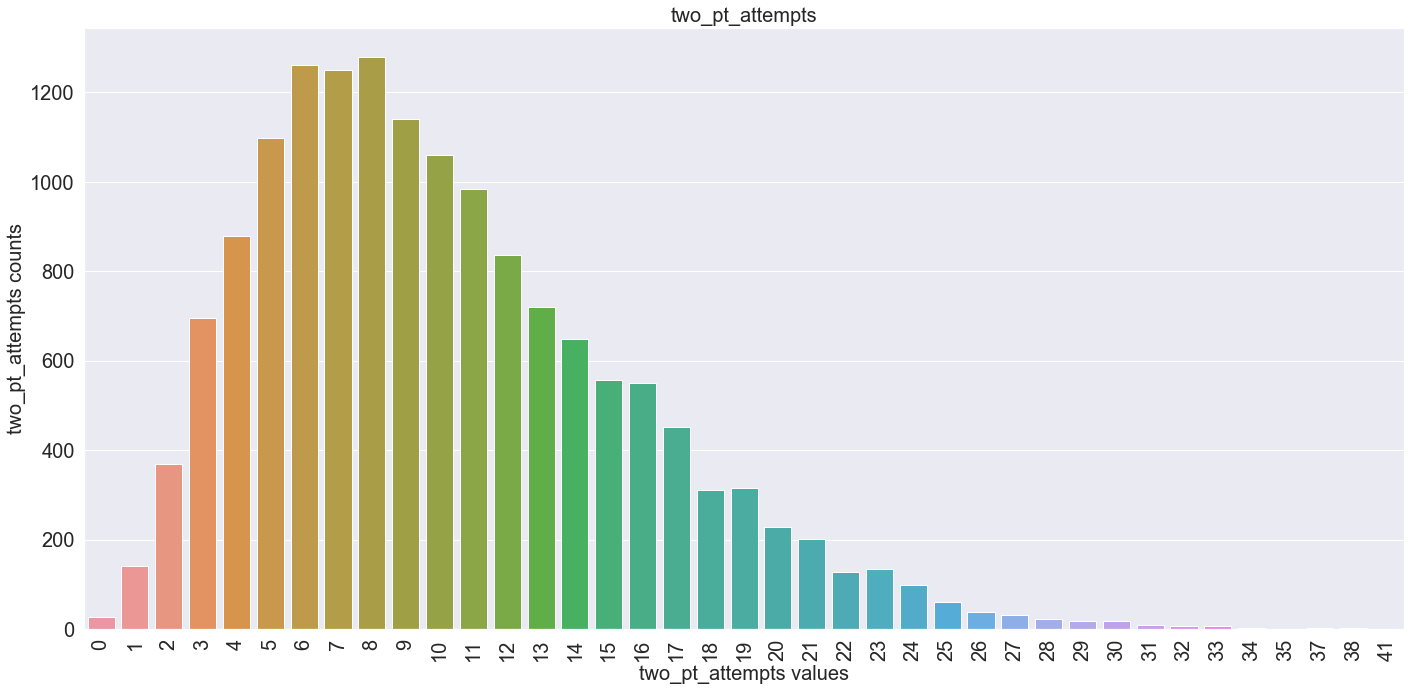

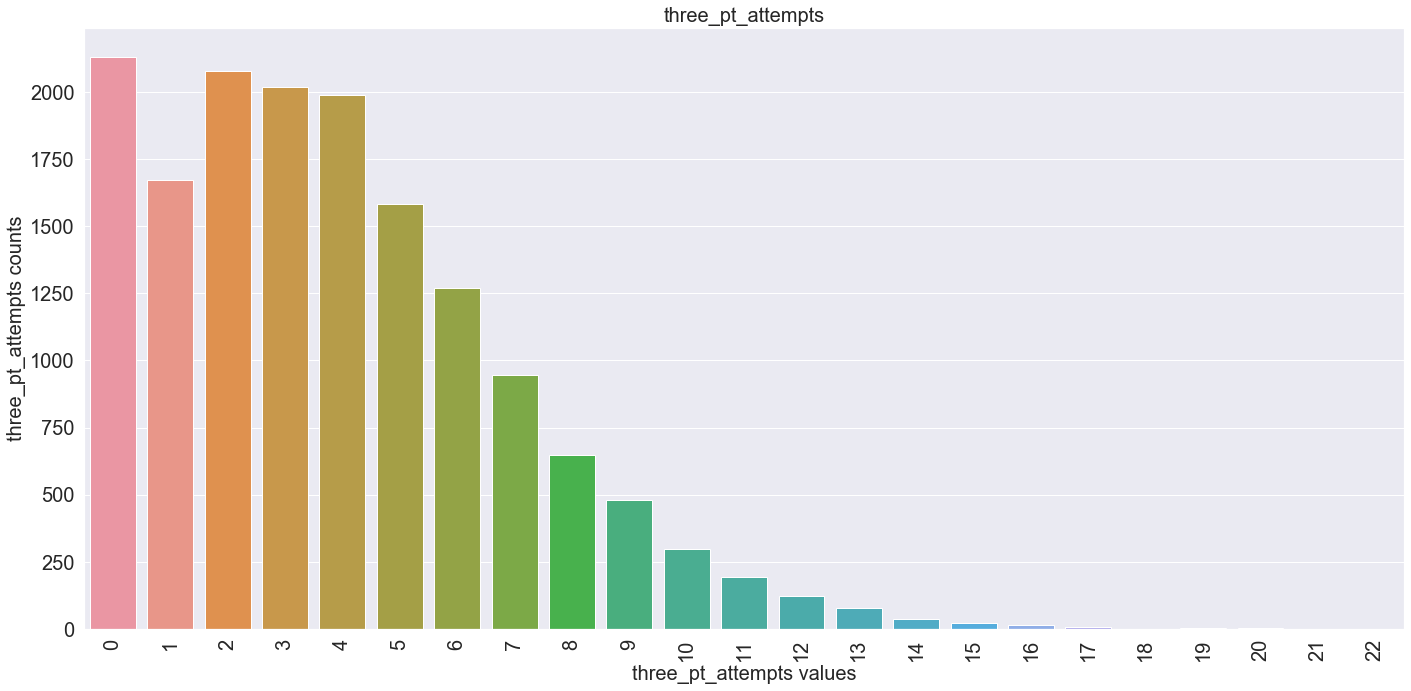

In [69]:
# plt.rc("font", size=20)
plt.rc("axes", labelsize=20)
plt.rc("axes", titlesize=20)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

for col in PERF_GRADING_NUMERIC_COLS:
    fig, ax = plt.subplots(figsize=(20, 10))
    ax = sns.countplot(data=df, x=col, ax=ax)
#     ax = df[col].value_counts().plot.bar(order=df[col].value_counts().index)
    ax.set(xlabel=f"{col} values", ylabel=f"{col} counts", title=col)
    plt.xticks(rotation=90)
    plt.tight_layout();
    plt.show();

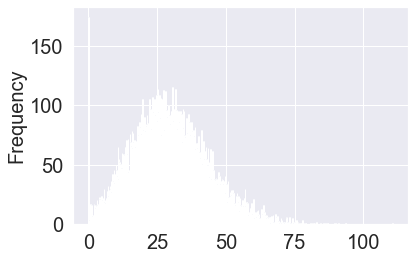

In [70]:
df.performance_score.plot.hist(bins=500);

## Analyzing any particular team

In [71]:
def analyze_team(team_name: str, **kwargs) -> None:
    team_df = df.loc[df.own_team_name == team_name]
    if team_df.empty:
        return
    return team_df.groupby("player_name").agg({"performance_score": ["mean", "std"]})\
        .sort_values(by=("performance_score", "mean")).plot.bar(title=team_name);

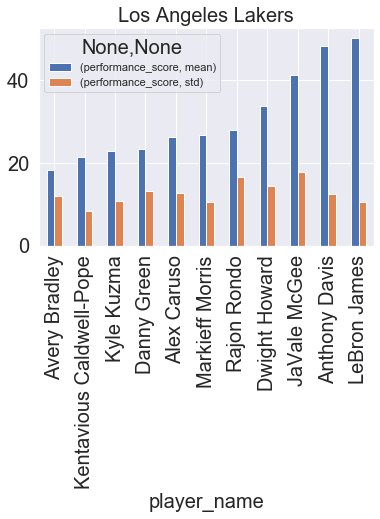

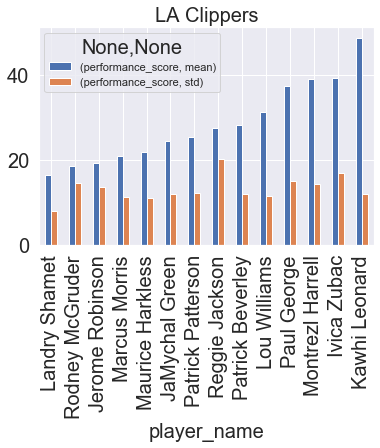

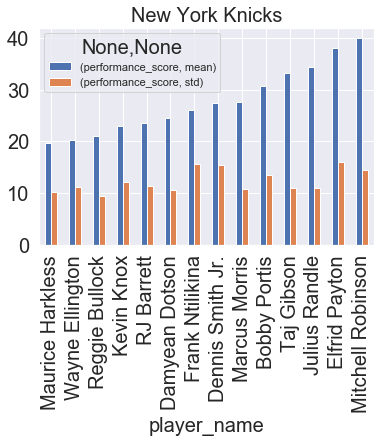

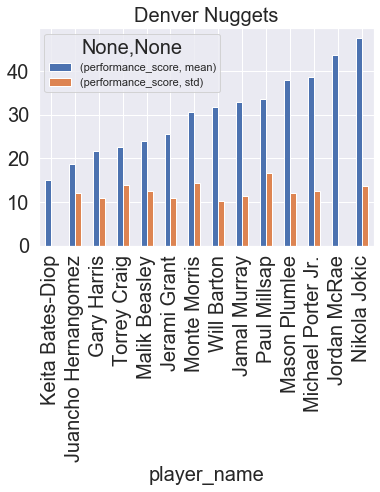

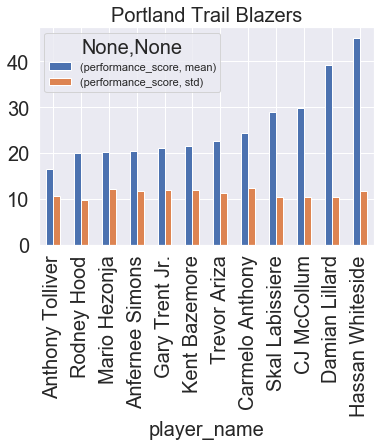

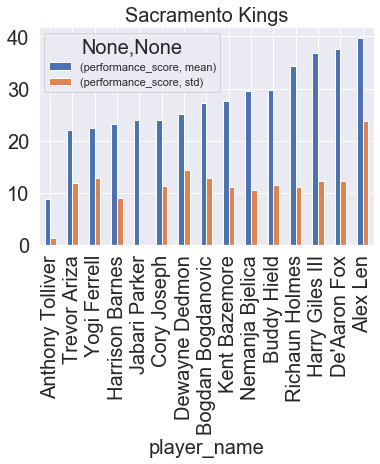

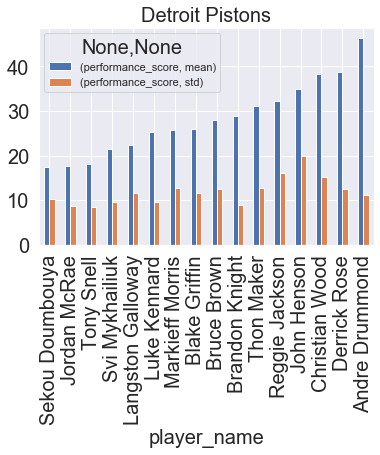

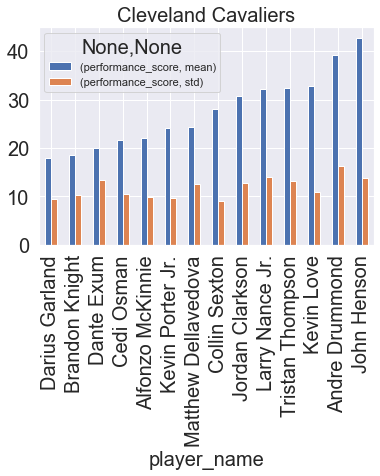

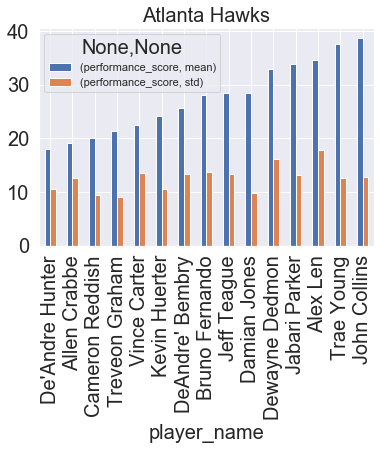

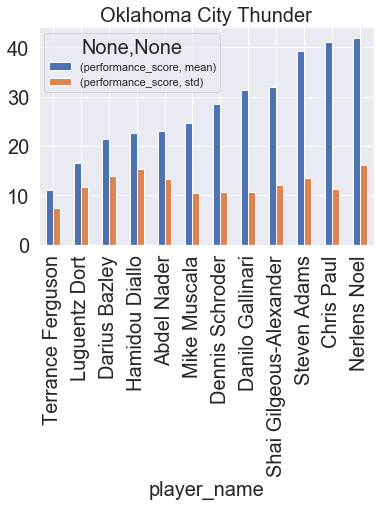

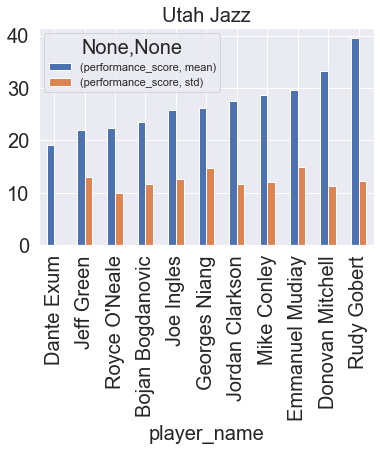

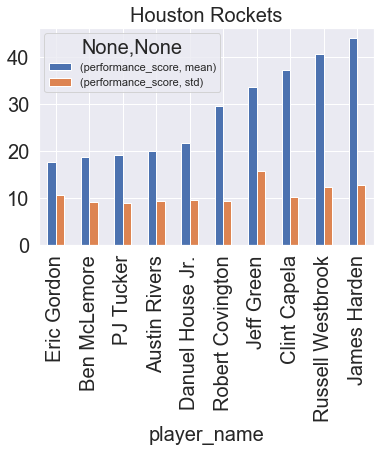

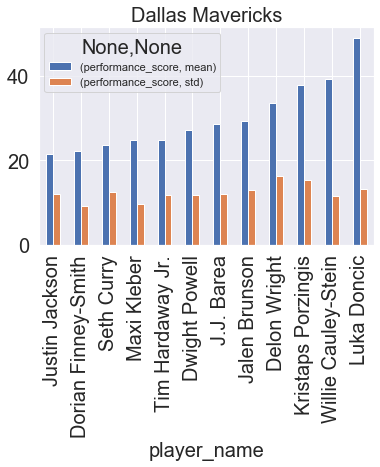

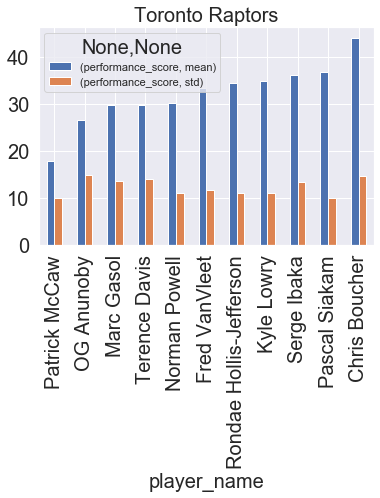

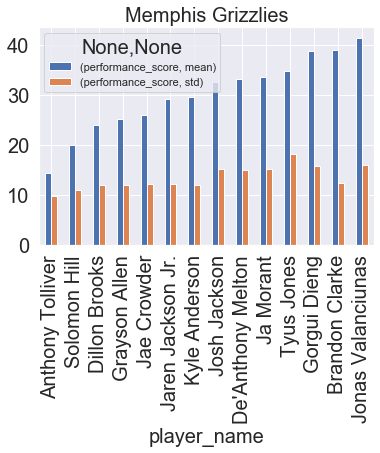

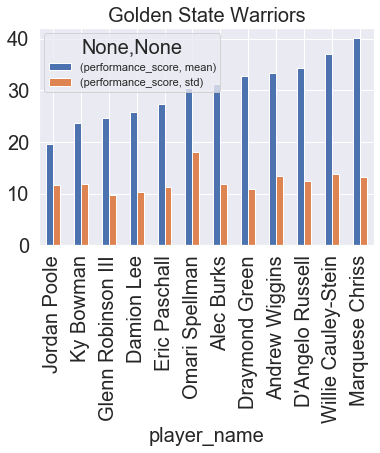

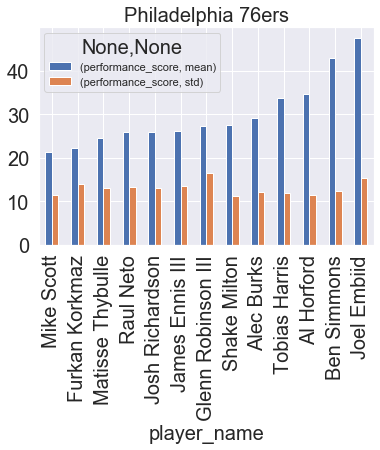

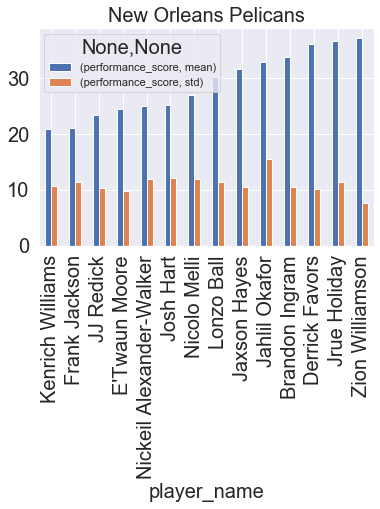

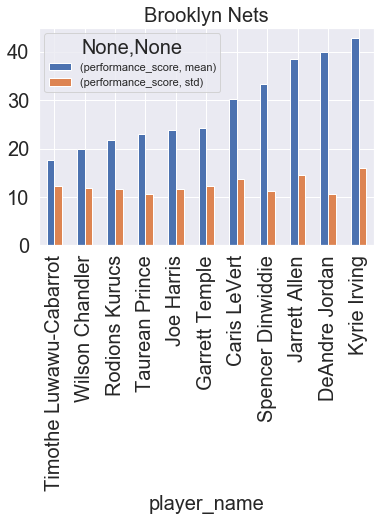

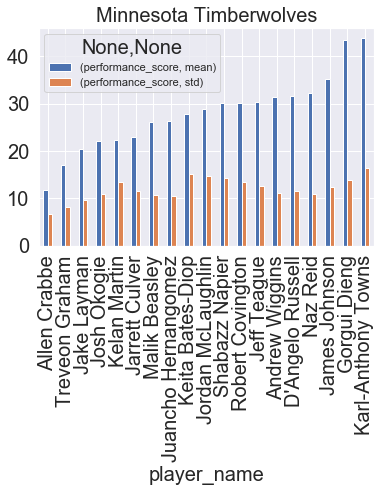

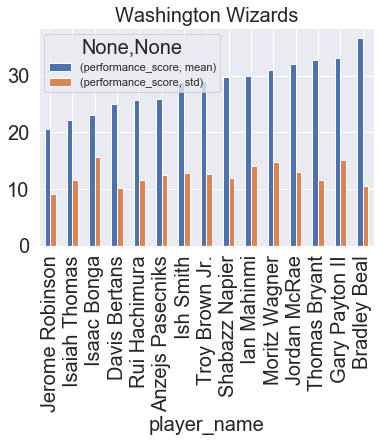

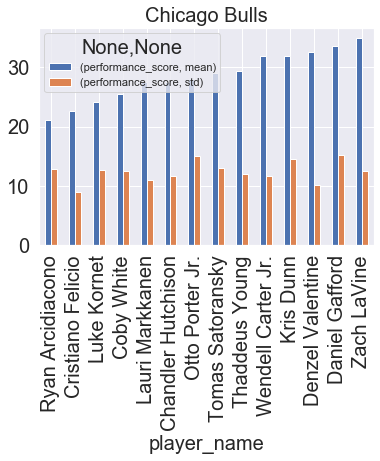

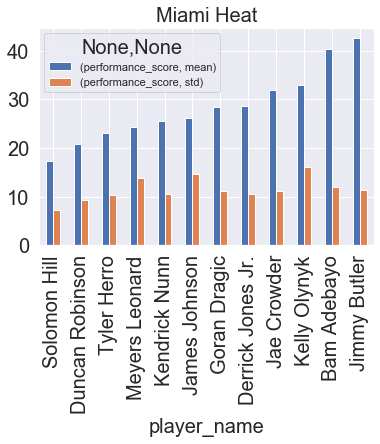

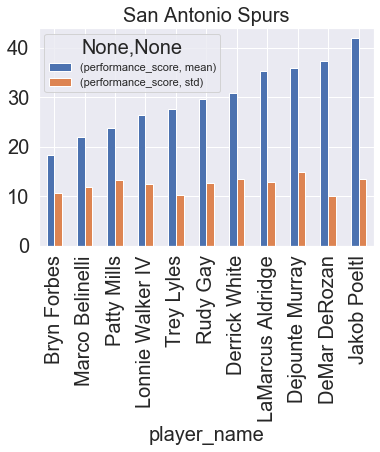

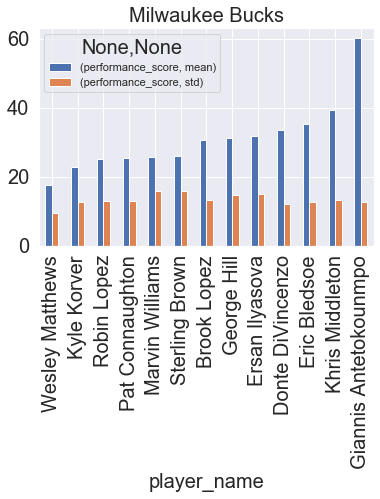

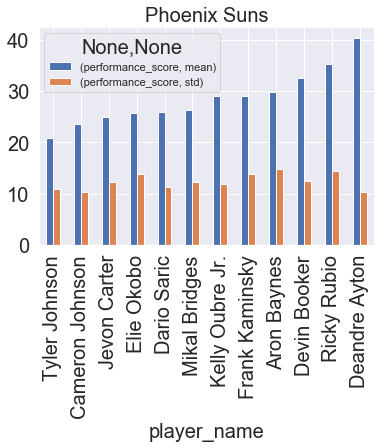

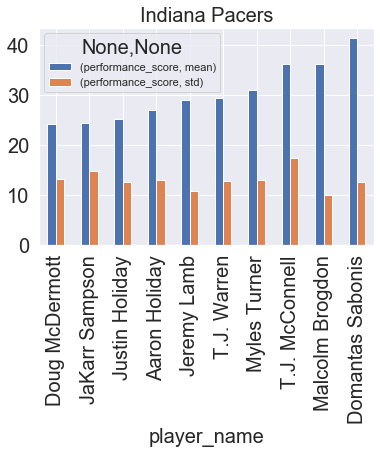

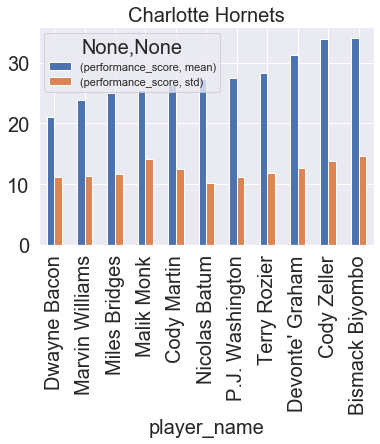

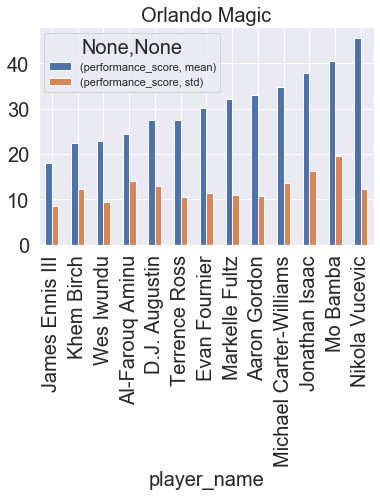

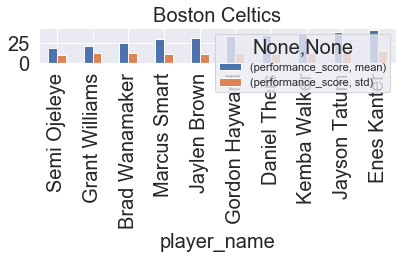

In [73]:
# analyze_team("Milwaukee Bucks")
team_names = list(df.own_team_name.unique())
# fig, ax = plt.subplots(nrows=len(team_names) // 3 + len(team_names) % 3, ncols=3, sharey=True)
fig.set_figheight(100); fig.set_figwidth(20)
for idx, team in enumerate(team_names):
    plot = analyze_team(team, ax=ax, pos=idx)
    x_plot_pos, y_plot_pos = idx // 3, idx % 3
    ax[x_plot_pos, y_plot_pos] = plot

plt.tight_layout()
plt.show();

## Inspecting correlation between performance_score and winning

In [187]:
df_summed = df.groupby(["game_id", "own_team_id", "game_winning_team"])\
    .agg({"performance_score": "mean"})

In [188]:
#df_games_played

In [189]:
df_summed.reset_index(inplace=True)
df_summed["is_winning_team"] = df_summed\
    .apply(lambda x: x['own_team_id'] == x["game_winning_team"], axis=1)
df_summed["has_highest_score"] = df_summed\
    .apply(lambda s: s["performance_score"] == df_summed.groupby("game_id")\
               .agg({"performance_score": "max"}).loc[s.game_id], axis=1)

df_summed["highest_score_did_win"] = df_summed.apply(lambda s: s.is_winning_team == s.has_highest_score, axis=1)
df["home_team_did_win"] = df.apply(lambda s: s["game_winning_team"] == s["game_object"].get("home_team_id"), axis=1)

In [192]:
team_winrates_df = df.drop_duplicates(subset=["game_id", "own_team_id"], inplace=False)

In [203]:
team_winrates_df.groupby("own_team_id").agg({"own_team_won": "sum"})

,own_team_won
own_team_id,
1,20.0
2,43.0
3,30.0
4,23.0
5,22.0
6,19.0
7,39.0
8,42.0
9,18.0


In [190]:
# in 81% of all games, the team with the higher avg. performance score
# (across all its players with > mins_played_threshold := 14)
# also wins the game.
df_summed.highest_score_did_win.value_counts() / (df_summed.highest_score_did_win.value_counts().sum())

True     0.818856
False    0.181144
Name: highest_score_did_win, dtype: float64

In [74]:
df.groupby(["game_id", "own_team_id", "game_winning_team"])\
    .agg({"performance_score": ["sum", "mean", "max", "count"]})[:50]

performance_score             \
                                                    sum       mean   
game_id own_team_id game_winning_team                                
62585   13          13                       237.565690  29.695711   
        14          13                       186.589463  26.655638   
62586   4           4                        209.304764  26.163095   
        5           4                        249.798245  31.224781   
62588   6           22                       259.535822  28.837314   
        22          22                       308.210520  34.245613   
62592   7           7                        237.018972  26.335441   
        30          7                        215.431219  26.928902   
62594   8           8                        302.669995  33.629999   
        25          8                        165.176242  27.529374   
62595   24          24                       350.400823  38.933425   
        26          24                       150.377198  16.708578   
62596   21          29                       220.822456  24.535828   
        29          29                       221.495367  27.686921   
62597   1           1                        278.005306  30.889478   
        9           1                        217.619337  24.179926   
62598   11          17                       197.480747  28.211535   
        17          17                       340.208540  34.020854   
62599   10          13                       141.605844  23.600974   
        13          13                       279.338235  31.037582   
62600   2           2                        233.160309  33.308616   
        28          2                        160.983120  22.997589   
62601   4           18                       221.776480  27.722060   
        18          18                       307.252162  38.406520   
62602   3           3                        197.115184  24.639398   
        20          3                        162.047503  27.007917   
62603   5           5                        281.203618  31.244846   
        15          5                        290.166187  32.240687   
62605   7           7                        252.535607  31.566951   
        19          7                        269.551387  26.955139   
62606   8           8                        225.144364  28.143045   
        24          8                        191.747045  23.968381   
62609   16          16                       217.767135  27.220892   
        17          16                       186.033843  23.254230   
62610   9           23                       229.103318  25.455924   
        23          23                       182.701021  30.450170   
62611   1           1                        233.879178  29.234897   
        22          1                        274.788646  30.532072   
62612   2           2                        261.088805  37.298401   
        20          2                        191.196511  27.313787   
62613   6           6                        256.155316  28.461702   
        12          6                        168.360342  28.060057   
62614   5           28                       242.540722  24.254072   
        28          28                       298.841185  42.691598   
62615   11          11                       189.203118  27.029017   
        19          11                       167.661560  23.951651   
62617   26          29                       157.234371  17.470486   
        29          29                       301.109906  33.456656   
62618   13          24                       227.686377  25.298486   
        24          24                       246.559659  30.819957   

                                                         
                                              max count  
game_id own_team_id game_winning_team                    
62585   13          13                  44.844739     8  
        14          13                  52.935164     7  
62586   4           4                

In [80]:
df_eval = df.loc[:,['player_name', 'performance_score']]

In [81]:
df_eval2 = df_eval.groupby("player_name").agg({"performance_score": ["mean", "std"]})

In [83]:
df_eval3 = df_eval2.sort_values(df_eval2.columns[0])

In [84]:
df_eval3

performance_score           
                                   mean        std
player_name                                       
Terrance Ferguson             10.994108   7.406245
Anthony Tolliver              15.612151  10.172690
Landry Shamet                 16.390189   7.935975
Luguentz Dort                 16.501202  11.710377
Sekou Doumbouya               17.369340  10.357972
...                                 ...        ...
Anthony Davis                 48.348687  12.583695
Kawhi Leonard                 48.680712  11.991912
Luka Doncic                   48.952816  13.285835
LeBron James                  50.172916  10.511180
Giannis Antetokounmpo         60.089215  12.756235

[346 rows x 2 columns]

In [95]:
df_performance_eval = pd.DataFrame(df_eval3)
df_performance_eval = df_performance_eval.reset_index()
df_performance_eval.columns = ['player_name', 'avg_performance_score','avg_performance_deviation'] # change column names

In [96]:
df_performance_eval

,player_name,avg_performance_score,avg_performance_deviation
0,Terrance Ferguson,10.994108,7.406245
1,Anthony Tolliver,15.612151,10.172690
2,Landry Shamet,16.390189,7.935975
3,Luguentz Dort,16.501202,11.710377
4,Sekou Doumbouya,17.369340,10.357972
...,...,...,...
341,Anthony Davis,48.348687,12.583695
342,Kawhi Leonard,48.680712,11.991912
343,Luka Doncic,48.952816,13.285835
344,LeBron James,50.172916,10.511180


In [97]:
df_performance_eval.set_index(['player_name'])

,avg_performance_score,avg_performance_deviation
player_name,,
Terrance Ferguson,10.994108,7.406245
Anthony Tolliver,15.612151,10.172690
Landry Shamet,16.390189,7.935975
Luguentz Dort,16.501202,11.710377
Sekou Doumbouya,17.369340,10.357972
...,...,...
Anthony Davis,48.348687,12.583695
Kawhi Leonard,48.680712,11.991912
Luka Doncic,48.952816,13.285835


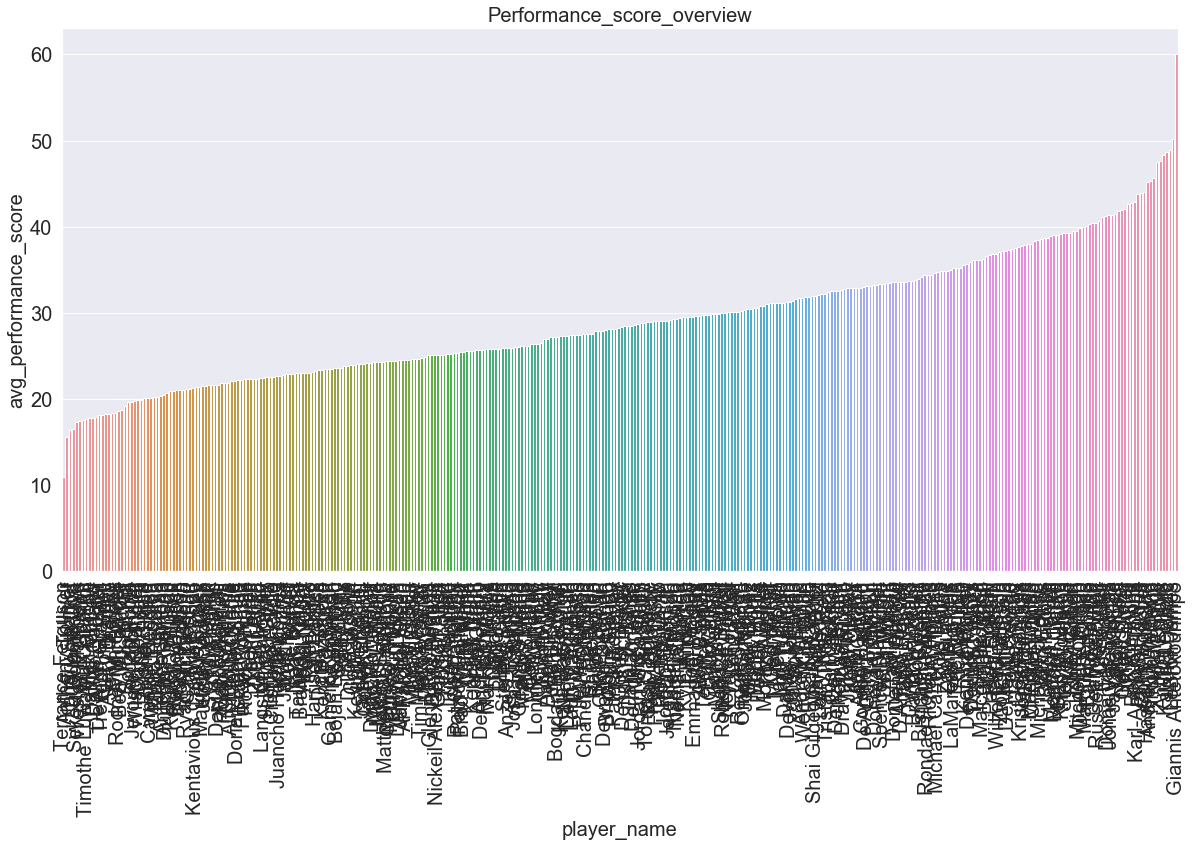

In [104]:
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="player_name", y="avg_performance_score", data=df_performance_eval, ax=ax)
# plt.bar(df_performance_eval['player_name'], df_performance_eval['avg_performance_score'])
plt.xlabel('player_name')
plt.ylabel("avg_performance_score")
plt.title("performance_score_overview")
plt.xticks(rotation=90)
plt.show();

In [38]:
df_performance_eval.describe()

,avg_performance_score,avg_performance_deviation
count,346.000000,346.000000
mean,29.192878,12.345384
std,7.332323,1.978342
min,10.994108,7.406245
25%,23.659785,10.935226
50%,28.338539,12.161558
75%,33.574488,13.382786
max,60.089215,19.536736


In [106]:
from sklearn.preprocessing import MinMaxScaler

In [108]:
df_performance_eval.columns

Index(['player_name', 'avg_performance_score', 'avg_performance_deviation'], dtype='object')

In [109]:
scaler = MinMaxScaler()
df_performance_eval['scaled_perf'] = (scaler.fit_transform(df_performance_eval['avg_performance_score'].values.reshape(-1,1)))*100
df_performance_eval['scaled_perf']  = round(df_performance_eval['scaled_perf'],2)

df_performance_eval['scaled_std'] = (scaler.fit_transform(df_performance_eval['avg_performance_deviation'].values.reshape(-1,1)))*100
df_performance_eval['scaled_std'] = round(df_performance_eval['scaled_std'],2)

df_performance_eval['scaled_perf']

0        0.00
1        9.41
2       10.99
3       11.22
4       12.99
        ...  
341     76.09
342     76.76
343     77.32
344     79.80
345    100.00
Name: scaled_perf, Length: 346, dtype: float64

In [110]:
df_performance_eval['scaled_std']

0       0.00
1      22.81
2       4.37
3      35.48
4      24.33
       ...  
341    42.68
342    37.80
343    48.47
344    25.60
345    44.10
Name: scaled_std, Length: 346, dtype: float64

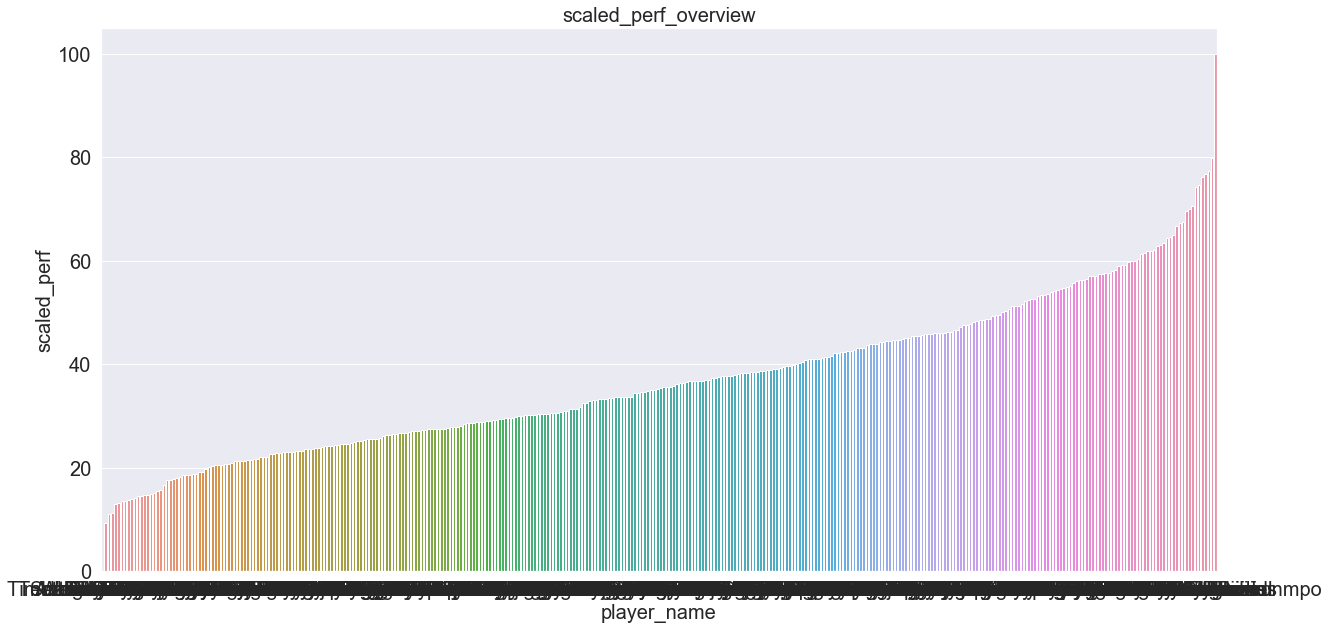

In [112]:
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="player_name", y="scaled_perf", data=df_performance_eval, ax=ax)
# plt.bar(df_performance_eval['player_name'], df_performance_eval['scaled_perf'])
plt.xlabel('player_name')
plt.ylabel("scaled_perf")
plt.title("scaled_perf_overview")
plt.show();

In [113]:
df_performance_eval_std = df_performance_eval.sort_values(df_performance_eval.columns[2])

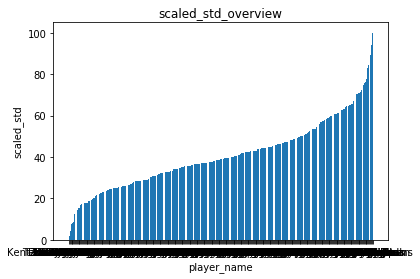

In [49]:
plt.figure()
plt.bar(df_performance_eval_std['player_name'], df_performance_eval_std['scaled_std'])
plt.xlabel('player_name')
plt.ylabel("scaled_std")
plt.title("scaled_std_overview")
plt.show();

In [51]:
df_performance_eval

,player_name,avg_performance_score,avg_performance_deviation,scaled_perf,scaled_std
0,Terrance Ferguson,10.994108,7.406245,0.00,0.00
1,Anthony Tolliver,15.612151,10.172690,9.41,22.81
2,Landry Shamet,16.390189,7.935975,10.99,4.37
3,Luguentz Dort,16.501202,11.710377,11.22,35.48
4,Sekou Doumbouya,17.369340,10.357972,12.99,24.33
...,...,...,...,...,...
341,Anthony Davis,48.348687,12.583695,76.09,42.68
342,Kawhi Leonard,48.680712,11.991912,76.76,37.80
343,Luka Doncic,48.952816,13.285835,77.32,48.47
344,LeBron James,50.172916,10.511180,79.80,25.60
